In [1]:
# Code to get central vs sidelobe flux for different 'phase differences'
# Import our packages
import dLuxToliman as dlT
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax.numpy as np

In [2]:
# --- AFTER IMPORTING PACKAGES, START FROM HERE CONNOR ---
# Cool. Let's let it run for 10 values between 0.1pi and 1 pi
# Gonna do just airy disk toliman
wf_npixels = 1024 # lower res 
diameter = 0.125
period = diameter/64 # longer period

psf_npixels = 64
pixel_scale = 1 
oversample = 8 # high level oversample

wavelengths = np.array([585e-9])
flux = 1
source = dl.PointSource(wavelengths, np.zeros(2), flux)

differences = np.pi * np.arange(0, 2.6, 0.1)
centre_fluxes = np.zeros_like(differences)
sidelobe_fluxes = np.zeros_like(differences)

In [3]:
# --- IMPORTANT INFO ---
# In my original code, I've modified the dluxtoliman package to simulate these layers in 1 line
# So you need to either update your own installing by pasting it or I need to push

pupilLayer = dlT.TolimanPupilLayer(wf_npixels)

for idx, difference in enumerate(differences):
    
    apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
    gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)
    gratingLayerInversion = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,True)


    layers = [
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayerInversion
        ),
        (
            'pupil',
            pupilLayer
        )
    ]

    optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
    # sidelobe layer for bottom left corner
    sidelobeShiftLayer = dlT.SidelobeShiftLayer(wf_npixels, diameter, period, wavelengths[0], pixel_scale, oversample)

    sidelobeLayers = [
        (
            'sidelobeShift',
            sidelobeShiftLayer
        ),
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayer
        )
    ]

    opticsLobe = dl.AngularOpticalSystem(wf_npixels,diameter,sidelobeLayers,psf_npixels,pixel_scale,oversample)

    psf = optics.model(source)
    psfLobe = opticsLobe.model(source)

    # saving the fluxes
    centre_fluxes = centre_fluxes.at[idx].set(np.sum(psf))
    
    sidelobe_fluxes = sidelobe_fluxes.at[idx].set(np.sum(psfLobe))

    print(centre_fluxes[idx], sidelobe_fluxes[idx])

0.92337584 0.00050847826
0.9176991 0.0020305512
0.9008514 0.0065003303
0.87337327 0.013671635
0.8361366 0.023150448
0.79030645 0.034418732
0.7372858 0.046864823
0.6786528 0.059819724
0.6160915 0.07259597
0.55132043 0.08452672
0.48602086 0.095003344
0.4217695 0.1035081
0.35998312 0.10964132
0.30187014 0.1131397
0.24839674 0.113886796
0.20026699 0.1119138
0.15791719 0.1073914
0.12152374 0.10061384
0.091023766 0.091975614
0.06614557 0.081944406
0.046447523 0.07102895
0.031361546 0.059747968
0.02023888 0.048599258
0.0123948315 0.038031846
0.007150397 0.028423712
0.003868092 0.020064462


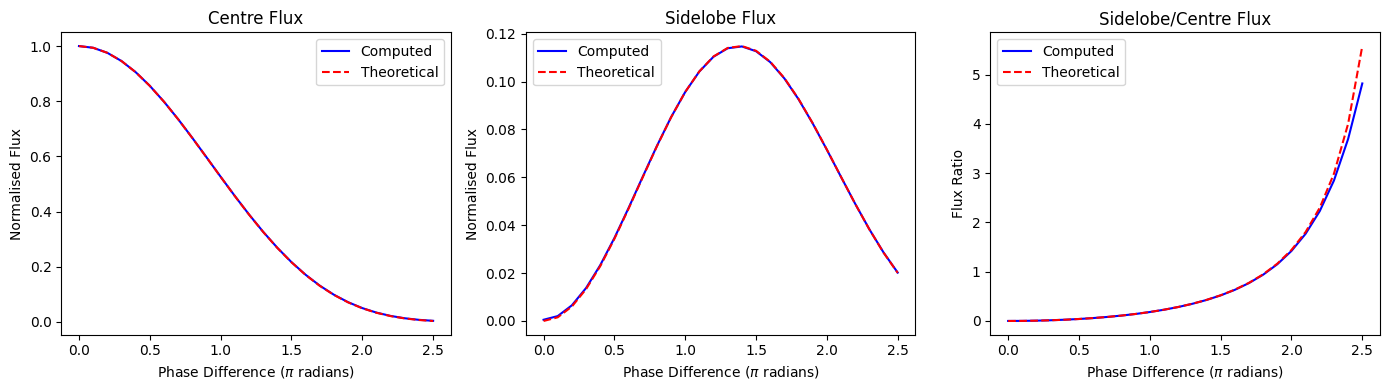

In [4]:
# from week 11 new stuff
from scipy.special import jv

norm_factor = 1/centre_fluxes[0]
norm_factor_lobe = (jv(0, differences[10]/4)**2 *  jv(1, differences[10]/4)**2)/sidelobe_fluxes[10]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi, centre_fluxes*norm_factor, label='Computed', color='blue')
plt.plot(differences/np.pi, jv(0, differences/4)**4 , label='Theoretical', linestyle='--', color='red')
plt.legend()

plt.subplot(1,3,2)
plt.title('Sidelobe Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi,sidelobe_fluxes*norm_factor_lobe, label = 'Computed', color='blue')
plt.plot(differences/np.pi, (jv(0, differences/4)**2 * jv(1, differences/4)**2), label =  'Theoretical', linestyle='--',color='red')
plt.legend()

plt.subplot(1,3,3)
plt.title('Sidelobe/Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Flux Ratio')
plt.plot(differences/np.pi,sidelobe_fluxes*norm_factor_lobe/(centre_fluxes*norm_factor),label='Computed',color='blue')
#plt.plot(x_fit, y_fit,label='Quartic fit (no const./linear terms)',linestyle=':')

plt.plot(differences/np.pi, jv(1, differences/4)**2/jv(0, differences/4)**2,label='Theoretical',linestyle='--',color='red')

plt.legend()

plt.tight_layout()
#plt.savefig('better_fluxes_improved.pdf')
plt.show()